# An Overview of Perceptually Relevant Metrics of Audio Similarity for Potential Use as Loss In Training Neural Networks

There are several areas that need thorough exploration:
- conventional loss functions
   - equipped with some modification to improve their perceptual relevance
   - like pre-emphasis
- complex perception focused metrics
   - mostly focused on quality assessment
   - may need some modification as well
- trained models
   - least "safe" method but likely best performing *as long as the inputs are similar to training dataset*

General notes from the literature:

- Amos Tversky researched similarity, perception, and categorization from psychology point of view. He noted human perception does not satisfy the definition of a euclidean metric [[1]](#references).
- Large portion of "music similarity" research focuses on clustering music with the aim of content delivery optimization [[1]](#references).
- MFCC based distance may be helpful [[1]](#references) (not directly mentioned) and there should be a way to make mel-cepstral distance differentiable [[2]](#references).
- 

Personal comments:

- Before settling for any similarity metric we first need to decide, whether the compared signals have to be produced with the same input signal
   - A guitar player may be able to tell if two systems are similar (or the same) even when hearing two different riffs played through them
   - Metric which does not require the same input signals on both compared systems may be helpful in some cases


## Conventional Loss

- Pros
   - easy to use
   - easy to represent
   - works the same regardless of data
   - not computationally demanding
- Cons
   - perceptually irrelevant
   - relevance can only be improved to a limited degree

Conventional loss (MSE, log-cosh,...) works well for general tasks, but is completely unrelated to human perception. However it might be usable when improved with some form of pre-emphasis (A-filtering?).



## Perception Focused Metrics

- Pros
   - perceptually relevant
   - possible (though possibly difficult) to represent
- Cons
   - may not be easy to use
   - could be computationally too complex

### Notes From Literature

- Objective models for prediction of pereptual quality can be divided into two categories: parameter-based (ITU-T G.107) and signal-based [[4]](#references).
   - Since parameter-based models like ITU-T G.107 are based on modeling communication line characteristics [[4, 5]](#references), only signal-based parameters are considered in our research.
   - Signal-based models can be further divided into no-reference and full-reference [[4]](#references). *Only full-reference models are considered for our use case.*

- PEMO-Q [[3]](#references)
   - PEMO-Q was created for lossy compression evaluation [[3]](#references).
   - Attempts to answer the problem of doubts about PEAQ being a realistic and valid model of general auditory perception [[3]](#references).
   - Auditory model
      - The signals are preprocessed in a way that may not be suitable for our problem [[3]](#references).
      - After preprocessing, the signals are transformed into "internal representation" using an auditory signal processing model [[3]](#references).
         - 35-band gammatone filterbank (basilar membrane characteristics) with each band then processed individually
         - half-wave rectification and low pass filter at 1 kHz (transformation of mechanical oscillations to neural firing rates of the inner haircells)
         - absolute hearing threshold determined from assumed maximum signal input
         - sequence of five nonliear feedback loops
            - dividing element and a low-pass (RC)
            - input is divided by low passed output
         - linear modulation filterbank, the most significant difference from previous work
            - a simplified version of PEMO-Q replaces this part with modulation-low-pass version of the auditory model (less accurate but less computationally difficult)
      - Lastly, cognitive effects are modeled in post-processing stage [[3]](#references).
   - Each channel of the outputs of auditory model are then cross correlated, which (after a weighed sum) gives a perceptual quality measure called PSM [[3]](#references).
   - PEMO-Q also defines a second, more detailed (in time) measure called PSM<sub>t</sub>, which is likely not of significance for our work [[3]](#references).
   - When using the computationally less demanding version, PEMO-Q is signal dependent [[3]](#references).
   - The correlation between the PSM and subjective ratings is higher than between PSM<sub>t</sub> and subjective ratings as long as only one type of signals is studied [[3]](#references).
   - According to the paper, it should be applicable more generally than PEAQ, but is not suitable for predicting impact of linear systems [[3]](#references).

- ViSQOLAudio [[4], [6], [7]](#references)
   - ViSQOL is an objective speech quality signal-based full-reference model published in 2015 [[6]](#references) and last updated in 2020 [[7]](#references).
   - It was later modified to create a more general model, ViSQOLAudio [[4]](#references).
   - ViSQOL is based on calculating NSIM, basically SSIM applied to neurograms [[6]](#references)
   - Model is very similar to ViSQOL (below), but has a VAD for active patch selection and originally used polynomial Q to Q<sub>MOS</sub> mapping [[6], [7]](#references).
   - VISQOLAudio is VISQOL modified to evaluate lossy compression. [[4]](#references).
   - The introduction of machine learning and output of MOS [[4]](#references) may mean original VISQOL could be better for our use case.
   - According to authors of the papers, VISQOLAudio is the first free and open source audio quality metric with accuracy comparable to proprietary metrics used in the industry [[4]](#references).
   - The model has four stages: preprocessing, pairing, comparison, and similarity to quality mapping [[4]](#references).
      - Preprocessing
         - Preprocessing starts with mid channel extraction [[4]](#references). *This step is irrelevant in our case as we intend to only work with mono audio signals.*
         - Next step is alignment process, which is meant to remove subframe misalignments caused by encoder padding [[4]](#references).
         - Lastly, the "degraded" signal is scaled to match reference signal power and Gammatone spectrograms are created [[4]](#references).
      - Pairing
         - Spectrograms are segmented into patches, ordered set of subsections of the spectrograms in respect to time [[4]](#references).
         - Patch pairs with the best similarity obtained using the Neurogram Similarity Index Measure (NSIM) are then found and most similar degraded patch is selected for each reference patch [[4]](#references). The information about which patch pair yield the best result will be used in the last step [[4]](#references) *This step may be problematic when modifying the metric to suit our needs, but as we do not need the similarty measure mapped to MOS, it may be possible to skip it.*
      - Comparison
         - NSIM is calculated for each patch pair, generating a tensor (NSIM is a vector containing a score for each frequency band) of NSIM scores [[4]](#references).
         - Patch pair NSIMs selected in step 2 are averaged to obtain a single value [[4]](#references).
      - Similarity to quality mapping
         - Similarity score is fed into a support vector regression model to obtain MOS estimate [[4]](#references).

- PEAQ [[9]](#references)
   - ITU recommendation BS.1387
   - Comes in two versions, basic and advanced, where the basic should allow for a cost-efficient real time implementation and the advanced should be more accurate [[9]](#references)
   - The algorithm calculates Model Output Variables (MOVs) and estimates MOS based on them [[9]](#references)
      - MOVs is a set of extracted features (described later)
      - MOS is obtained by feeding MOVs into a neural network
   - PEAQ incorporates several other models to obtain the MOVs [[9]](#references)
      - DIX
      - NMR
      - OASE
      - PAQM
      - PERCEVAL
      - POM
   - "basic audio quality"
      - Basic version uses 11 MOVs calculated from FFT-based ear model, advanced version uses 5 MOVs calculated from both FFT-based and filterbank-based model [[9]](#references)
   - FFT-based ear model
      - figure 9 in [[9]](#references)
      - 48 kHz time aligned signals segmented into .042 s windows with 50% overlap
      - STFT with Hann window, scaling
      - A-wighing
      - transform to pitch representation
      - internal noise simulation
      - spreading in spectral domain (?)
      - spreading in time domain (?)
      - pre-processing of extracted features
         - masker calculation
         - loudness calculation
         - modulation patterns calculation
         - ...
   - filterbank-based model (advanced model only)
      - scaling to playback level, highpass filter
      - decomposition into f bands corr to perceptual pitch scale
      - weighing
      - spreading in frequency domain
      - hilbert transform
      - time domain spreading
      - internal noise simulation
      - another time domain spreading
   - 


- PAQM

- PERCEVAL

- ~~POLQA and POLQA Music~~
   - seems like POLQA Music does not exist or is not publicly available

- Comparison of PEAQ x POLQA x PEMO-Q x ViSQOLAudio [[4]](#references)
   - From fig. 4 in [[4]](#references) it seems all metrics perform relatively well, but mostly show varying results depending on the used dataset.
      - ViSQOLAudio seems to be the most consistent of the tested metrics [[4]](#references).
   - PEMO-Q and ViSQOLAudio both seem to generally fit well to the subjective scores [[4]](#references).
   - PEAQ consistently gives lower score, especially in AACvOpus15 dataset [[4]](#references).
   - POLQA performance depends on the used dataset, struggling on some data and performing well on other [[4]](#references).
   - When testing the evaluation metrics without achors:
      - ViSQOLAudio 
      - PEAQ and POLQA have large variation in prediction for high quality samples [[4]](#references).
   - Testing suggests PEAQ is sensitive to sample type [[4]](#references).
   - POLQA shows poor predictions for high-bitrate samples, which is likely because POLQA being intended for evaluation of speech signals interprets music as noise [[4]](#references).
   - 


## Trained Models

- Pros
   - perceptual relevance guaranteed by training dataset
   - should be easy to use
- Cons
   - any modification requires re-training the model
   - virtually impossible to represent
   - no guarantee of performance on data not represented in dataset

### Notes from Literature

- DPAM and CDPAM [[8]](#references)
   - Neural networks trained to perform as perceptual metric [[8]](#references)
   - No information about training dataset
      - Designed for audio with 22.05 kHz sample rate and compared to speech evaluation metrics only [[8]](#references)
      - Likely only suitable for speech signals and thus unsuitable for our needs

## Implementation

Torch does not contain dct, but there is a custom library on [GitHub](https://github.com/zh217/torch-dct).

Loss functions are implemented in [`percloss.py`]() file stored in [losslib folder]() and can be imported as:

In [1]:
import matplotlib.pyplot as plt
import torch
import torchaudio
import numpy as np

import losslib.percloss as pl

### MSeE

MSeE (Mean Squared emphasized Error) is a working title for MSE applied to signals with pre-emphasis.
The `MSeE` class constructor takes optional argument `type`, which specifies the type of preemphasis used:

In [59]:
msee0 = pl.MSeE(mode=0) # first order pre-emphasis
msee1 = pl.MSeE(mode=1) # A-weight
msee2 = pl.MSeE(mode=2) # most complex case (still a filter)
#msee3 = pl.MSeE(mode=3) # will not work

First order pre-emphasis is a first order FIR filter with values taken from [here](https://arxiv.org/html/2407.02672v1).
The A-weight filter coefficient are taken from [this pdf](https://jenshee.dk/signalprocessing/aweighting.pdf).
`type=2` option is not solved yet.


### Cepstral Distance

Cepstral distance is implemented in the `cepdist` class.
The constructor takes two optional arguments `type` and `p`.
`type` specifies whether LFCC (default), MFCC or PLPCC is used, `p` specifies the order in Minkowki distance between cepstra (default is 2).

In [3]:
lcd = pl.cepdist(mode='linear') # linear frequency cepstral coefficients
mcd = pl.cepdist(mode='mel')    # mel frequency cc
pcd = pl.cepdist(mode='plp')    # PLPCC

All cepstra are calculated in 128 sample windows with 64 sample overlap and Hann window.
only LFCC based distance is written (but untested as of yet).

#### TODO

- add Bark (BFCC), Gamatone (GFCC, GTCC), (modified) human factor frequency (HFCC, MHFCC)

### PEAQ

Due to the use of a pre-trained neural network in the last stage of PEAQ, the algorithm could not be significantly simplified.
The `PEAQ` class is an implementation of the Basic version of PEAQ.
The constructor takes no arguments.

In [ ]:
peaq=pl.PEAQ()

### PEMOQ

The algorithm in `PEAQ` class is somewhat simplified.

In [4]:
pemoq=pl.PEMOQ()

### ViSQOLoss

`ViSQOLoss` class contains a modified (mostly simplified) ViSQOLAudio algorithm.

In [3]:
vloss=pl.ViSQOLoss()

### Testing the Implemented Loss

A sample signal is loaded to show the function of the implemented loss function in terms of how they work with the data. The signal is nonlinearly distorted to create a similar but audibly different signal.

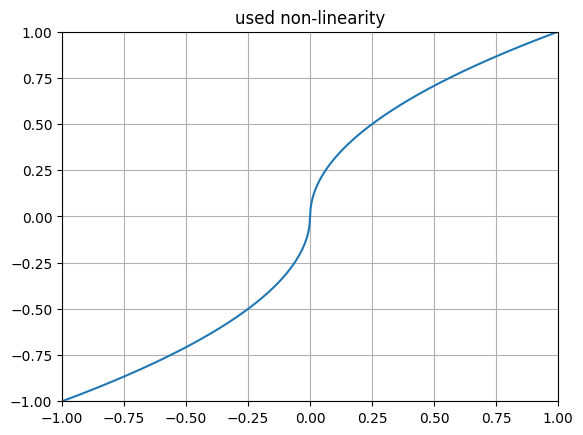

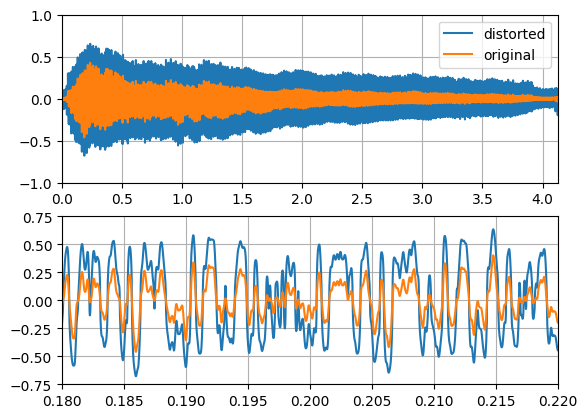

In [57]:
insig, fs = torchaudio.load('sample.wav')
distsig = torch.sgn(insig)*torch.sqrt(torch.abs(insig))
t = np.linspace(0, insig.size(1)/fs, num=insig.size(1))

t1 = np.linspace(-1, 1, num=500)
t2 = np.sign(t1)*np.sqrt(np.abs(t1))
plt.plot(t1,t2)
plt.grid()
plt.axis([-1,1,-1,1])
plt.title('used non-linearity')
plt.show()

f1, a1 = plt.subplots(2,1)
a1[0].plot(t, np.squeeze(distsig.to('cpu').detach().numpy()), label='distorted')
a1[0].plot(t, np.squeeze(insig.to('cpu').detach().numpy()),   label='original')
a1[0].legend()
a1[0].axis([0,t[-1],-1,1])
a1[0].grid()
a1[1].plot(t, np.squeeze(distsig.to('cpu').detach().numpy()), label='distorted')
a1[1].plot(t, np.squeeze(insig.to('cpu').detach().numpy()),   label='original')
a1[1].axis([0.18,0.22,-0.75,0.75])
a1[1].grid()
plt.show()

#### Mean Squared emphasised Error

the next figure shows the result of the various pre-emphasis filters.

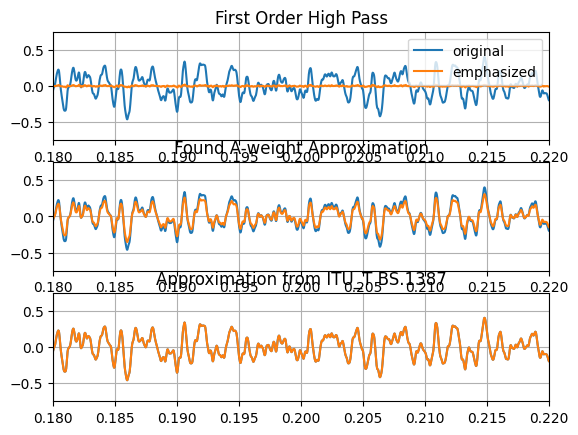

In [75]:
f2, a2 = plt.subplots(3,1)
a2[0].plot(t, np.squeeze(insig.to('cpu').detach().numpy()),   label='original')
a2[0].plot(t, np.squeeze(msee0.preem(insig).to('cpu').detach().numpy()), label='emphasized')
a2[0].axis([0.18,0.22,-0.75,0.75])
a2[0].legend()
a2[0].grid()
a2[0].set_title('First Order High Pass')
a2[1].plot(t, np.squeeze(insig.to('cpu').detach().numpy()),   label='original')
a2[1].plot(t, np.squeeze(msee1.preem(insig).to('cpu').detach().numpy()), label='emphasized')
a2[1].axis([0.18,0.22,-0.75,0.75])
a2[1].grid()
a2[1].set_title('Found A-weight Approximation')
a2[2].plot(t, np.squeeze(insig.to('cpu').detach().numpy()),   label='original')
a2[2].plot(t, np.squeeze(msee2.preem(insig).to('cpu').detach().numpy()), label='emphasized')
a2[2].axis([0.18,0.22,-0.75,0.75])
a2[2].grid()
a2[2].set_title('Approximation from ITU_T BS.1387')
plt.show()


# References
- [1] [A Large-Scale Evaluation of Acoustic and Subjective Music-Similarity Measures](https://www.jstor.org/stable/3681827)
- [2] [Embedding a Differentiable MEL-Cepstral Synthesis Filter to a Neural Speech Synthesis System](https://arxiv.org/pdf/2211.11222)
- [3] [PEMO-Q—A New Method for Objective Audio Quality Assessment Using a Model of Auditory Perception](https://ieeexplore.ieee.org/document/1709880)
- [4] [Objective Assessment of Perceptual Audio Quality Using ViSQOLAudio](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7940042)
- [5] [G.107 : The E-model: a computational model for use in transmission planning](https://www.itu.int/rec/T-REC-G.107-201506-I/en)
- [6] [ViSQOL: an objective speech quality model](https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-015-0054-9)
- [7] [ViSQOL v3: An Open Source Production Ready Objective Speech and Audio Metric](https://arxiv.org/abs/2004.09584)
- [8] [A Differentiable Perceptual Audio Metric Learned from Just Noticeable Differences](https://arxiv.org/abs/2001.04460)
- [9] [BS.1387-2 : Method for objective measurements of perceived audio quality](https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1387-2-202305-I!!PDF-E.pdf)

## Sources to go through

- [a] Auditory Feature-based Perceptual Distance
  - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10925319/
  - preprint (not reviewed yet)
  - uses a CNN in calculation
- [b] Audio retrieval based on perceptual similarity
  - https://ieeexplore.ieee.org/document/7014580
- [c] Modeling Perceptual Similarity of Audio Signals for Blind Source Separation Evaluation
  - https://www.researchgate.net/publication/220848024_Modeling_Perceptual_Similarity_of_Audio_Signals_for_Blind_Source_Separation_Evaluation
- [d] A Similarity Measure for Automatic Audio Classification
  - likely not too useful
  - https://cdn.aaai.org/Symposia/Spring/1997/SS-97-03/SS97-03-001.pdf
- [e] An Objective Metric of Human Subjective Audio Quality Optimized for a Wide Range of Audio Fidelities
  - https://ieeexplore.ieee.org/abstract/document/4358089
- [f] Music Popularity: Metrics, Characteristics, and Audio-Based Prediction
  - https://ieeexplore.ieee.org/abstract/document/8327835
- [g] POLQA Music
  - POLQA meant for evaluation of music signals
  - link to be added (can't find more than short reference in one of the ViSQOL papers)
  - likely does not exist or is not public (even POLQA is not open)
- [h] Can we still use PEAQ? A Performance Analysis of the ITU Standard for the Objective Assessment of Perceived Audio Quality
  - PEAQ x PEMO-Q x ViSQOLAudio comparison
  - https://arxiv.org/pdf/2212.01467
- [i] Perceptual Quality Assessment for Digital Audio: PEAQ-The New ITU Standard for Objective Measurement of the Perceived Audio Quality
  - https://aes2.org/publications/elibrary-page/?id=8055
- Formal listening test reccomendation
  - ITU-R BS.1116
- [k] Gammatone Filterbank Toolkit
  - https://github.com/detly/gammatone
- [l] Human Factor Cepstral Coefficients
  - https://www.researchgate.net/publication/237464711_Human_Factor_Cepstral_Coefficients

# Help From Others

### Metody hodnoceni zvuku od Vaska


>Ahoj,
>
>tady jsou nejake linky na systemy hodnoceni kvality zvuku, ktere by se mohly dat aplikovat na Tvuj problem.
>
>https://github.com/google/visqol Tohle je system, ktery je podle clanku obstojny a asi jeden z poslednich, o kterych vim. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7940042
>
>Tohle je starsi system, ktery ma jednodussi impementaci, takze mozna pro zacatek by byl rozumnejsi https://ieeexplore.ieee.org/document/1709880
>
>Obecne ty systemy vyuzivaji banky filtru zvanou gammatone filterbank, ktera se da najit treba tady https://amtoolbox.org/models.php Ten zbytek algoritmu by se mel taky dat najit v tom toolboxu a vyhodnoceni uz je pomoci rovnic, co se daji snadno implementovat.
>
>
>Ja sam jsem nikdy prakticky ty systemy nepouzil. Prevzal jsem rozhodovaci cast z PEMO-Q pro jeden konferencni prispevek. Tam jsem nahradil banku filtru necim, co by melo byt vernejsi funkci sluchu, ale zase je to vypocetne nesrovnale narocnejsi. Takze bych sam spise zacal od tech zavedenych signal processingovych postupu v odkazech. Kdyby jsi o funkci sluchu chtel vedet vic, pak mam v doktorske etape predmet.
>
>Vasek
